# Problem

Birds are a group of feathered, bipedal vertebrates endemic to all major landmasses.
They play crucial roles in many ecosystems by eating smaller animals such as insects,
serving as pollinators, and dispersing seeds; consequentially, their population and
distribution has a significant impact in agriculture and nature conservation.

Currently, the monitoring of bird population and distribution is done through a variety of
ways, including bird banding where birds are captured, banded, and released, and
through crowd sourced photography.i These methods are largely manual, are not suited
for remote areas, and suffer from availability bias. Monitoring birds through optical or
acoustic sensors is an ongoing area of research. Previous work has demonstrated the
applicability of decision trees in this area, however, deep-learning based approaches
offer a chance for improved accuracy.




# Setup


In [1]:
!pip show tensorflow;

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [2]:
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.8 MB/s eta 0:00:00


In [3]:
!pip install -q kaggle

In [4]:
import os
import sys
import random
import datetime

import tempfile
import zipfile

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()

import librosa
import librosa.display

from IPython.display import Audio, display, HTML

seed = 47
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

def get_gzipped_file(file):
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return zipped_file

# Download Data

The dataset exists on Kaggle, https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set, which requires authentication with Kaggle via a token. To download the dataset perform the following,

1. Go to your account, scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Upload the kaggle.json file that you downloaded by running the following,

In [5]:
from google.colab import files # required to fetch the data from kaggle

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aedenjameson","key":"1c13fc5227b481ff1cf7ea9b877ce4ac"}'}

4. Move the token file to the right place and give it the correct permissions

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

5. Verify the connection with Kaggle.

In [7]:
import kaggle

! kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shreyanshverma27/online-sales-dataset-popular-marketplace-data  Online Sales Dataset - Popular Marketplace Data      7KB  2024-05-25 23:55:26           3297         63  1.0              
devarajv88/walmart-sales-dataset                                e-Commerce (Walmart) Sales Dataset                   5MB  2024-05-30 12:09:55           2079         34  1.0              
ayushparwal2026/country-population-from-1960-to-2022            Country Population from 1960 to 2022                75KB  2024-05-31 08:58:26           1557         39  0.9411765        
mayankanand2701/apple-stock-price-dataset                       A

In [8]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('vinayshanbhag/bird-song-data-set', path='data/', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set


In [9]:
metadata = pd.read_csv("data/bird_songs_metadata.csv", sep=",")

# Prepare Data

# Explore the Data

First, gather basic impressions about the data.

* What metadata is there?
* How many rows are there and what are their types?
* Is predicted target imbalanced?


In [10]:
# @title What is in our data set?

metadata.sample(frac=.1).head(10)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
1946,21735,Mimus,polyglottos,NaN,Northern Mockingbird,Chris Parrish,United States,"Stateline Road, Rodeo, New Mexico",31.8270,-109.0489,1260,song,//www.xeno-canto.org/21735,//creativecommons.org/licenses/by-nc-nd/2.5/,08:06,2008-07-13,NaN,21735-2.wav
2008,18483,Mimus,polyglottos,NaN,Northern Mockingbird,Chris Parrish,United States,"Elk River, Franklin County, Tennessee",35.3037,-85.9467,296,song,//www.xeno-canto.org/18483,//creativecommons.org/licenses/by-nc-nd/2.5/,18:19,2008-03-13,NaN,18483-5.wav
4453,523589,Cardinalis,cardinalis,NaN,Northern Cardinal,William Whitehead,United States,"Ernest Oros Nature Preserve, Avenel, New Jersey",40.5874,-74.2621,0,"adult, male, song",//www.xeno-canto.org/523589,//creativecommons.org/licenses/by-nc-sa/4.0/,07:00,2020-02-01,Hardwoods and Fresh Water Swamp,523589-6.wav
1994,18484,Mimus,polyglottos,NaN,Northern Mockingbird,Chris Parrish,United States,"Elk River, Franklin County, Tennessee",35.3037,-85.9467,296,song,//www.xeno-canto.org/18484,//creativecommons.org/licenses/by-nc-nd/2.5/,18:24,2008-03-13,NaN,18484-4.wav
4743,382878,Cardinalis,cardinalis,NaN,Northern Cardinal,Bobby Wilcox,United States,"Tama (near Burlington), Des Moines, Iowa",40.8918,-91.0756,220,song,//www.xeno-canto.org/382878,//creativecommons.org/licenses/by-nc-sa/4.0/,08:00,2017-08-03,About 50ft away in deciduous forest.,382878-0.wav
1494,321913,Mimus,polyglottos,polyglottos,Northern Mockingbird,Richard E. Webster,United States,"San Simon Cienega, Cochise County, Arizona",32.0840,-109.0510,1100,song,//www.xeno-canto.org/321913,//creativecommons.org/licenses/by-nc-sa/4.0/,07:25,2015-05-05,singing now from the top of a couple of salt c...,321913-3.wav
329,351038,Thryomanes,bewickii,charienturus,Bewick's Wren,Richard E. Webster,United States,"Arrastre Creek at 3N03, San Bernardino Mountai...",34.2766,-116.7468,1700,song,//www.xeno-canto.org/351038,//creativecommons.org/licenses/by-nc-sa/4.0/,07:50,2000-07-09,NaN,351038-0.wav
2738,309318,Turdus,migratorius,NaN,American Robin,J.R. Rigby,United States,"Oxford, Lafayette County, Mississippi",34.3665,-89.5192,160,song,//www.xeno-canto.org/309318,//creativecommons.org/licenses/by-nc-sa/4.0/,08:00,2016-03-26,Natural sound. Bird singing from the lower bra...,309318-6.wav
1619,321786,Mimus,polyglottos,NaN,Northern Mockingbird,Sue Riffe,United States,"Picture Canyon, Baca County, Colorado",37.0089,-102.7467,1300,song,//www.xeno-canto.org/321786,//creativecommons.org/licenses/by-nc-sa/4.0/,14:54,2016-06-09,NaN,321786-8.wav
368,323981,Thryomanes,bewickii,eremophilus,Bewick's Wren,Richard E. Webster,United States,"Silver Creek, Cave Creek Canyon, Cochise Count...",31.9320,-109.1910,1500,song,//www.xeno-canto.org/323981,//creativecommons.org/licenses/by-nc-sa/4.0/,07:36,2015-05-02,volume increases over the length of the recording,323981-5.wav


In [11]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB


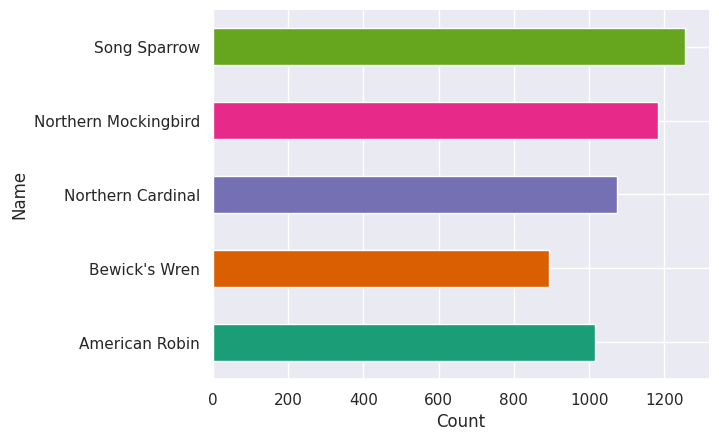

In [12]:
# @title Are the bird names distributed evenly?

bird_counts = metadata.groupby('name').size()

bird_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Count')
plt.ylabel('Name')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
print('Minimum samples per category = ', bird_counts.min())
print('Maximum samples per category = ', bird_counts.max())

Minimum samples per category =  893
Maximum samples per category =  1256


We observe that:

* The number of audio samples per category is non-uniform. The minimum number of audio samples in a category is 893 while the maximum is 1256

Consequently, we should consider balancing out the class representation, which reduces over-fitting on a particular class and can improve model accuracy.

## Examine Sounds

In [14]:
# select one of each bird type to examine

samples = metadata.groupby('name').apply(lambda x: x.sample(1)).reset_index(drop=True)

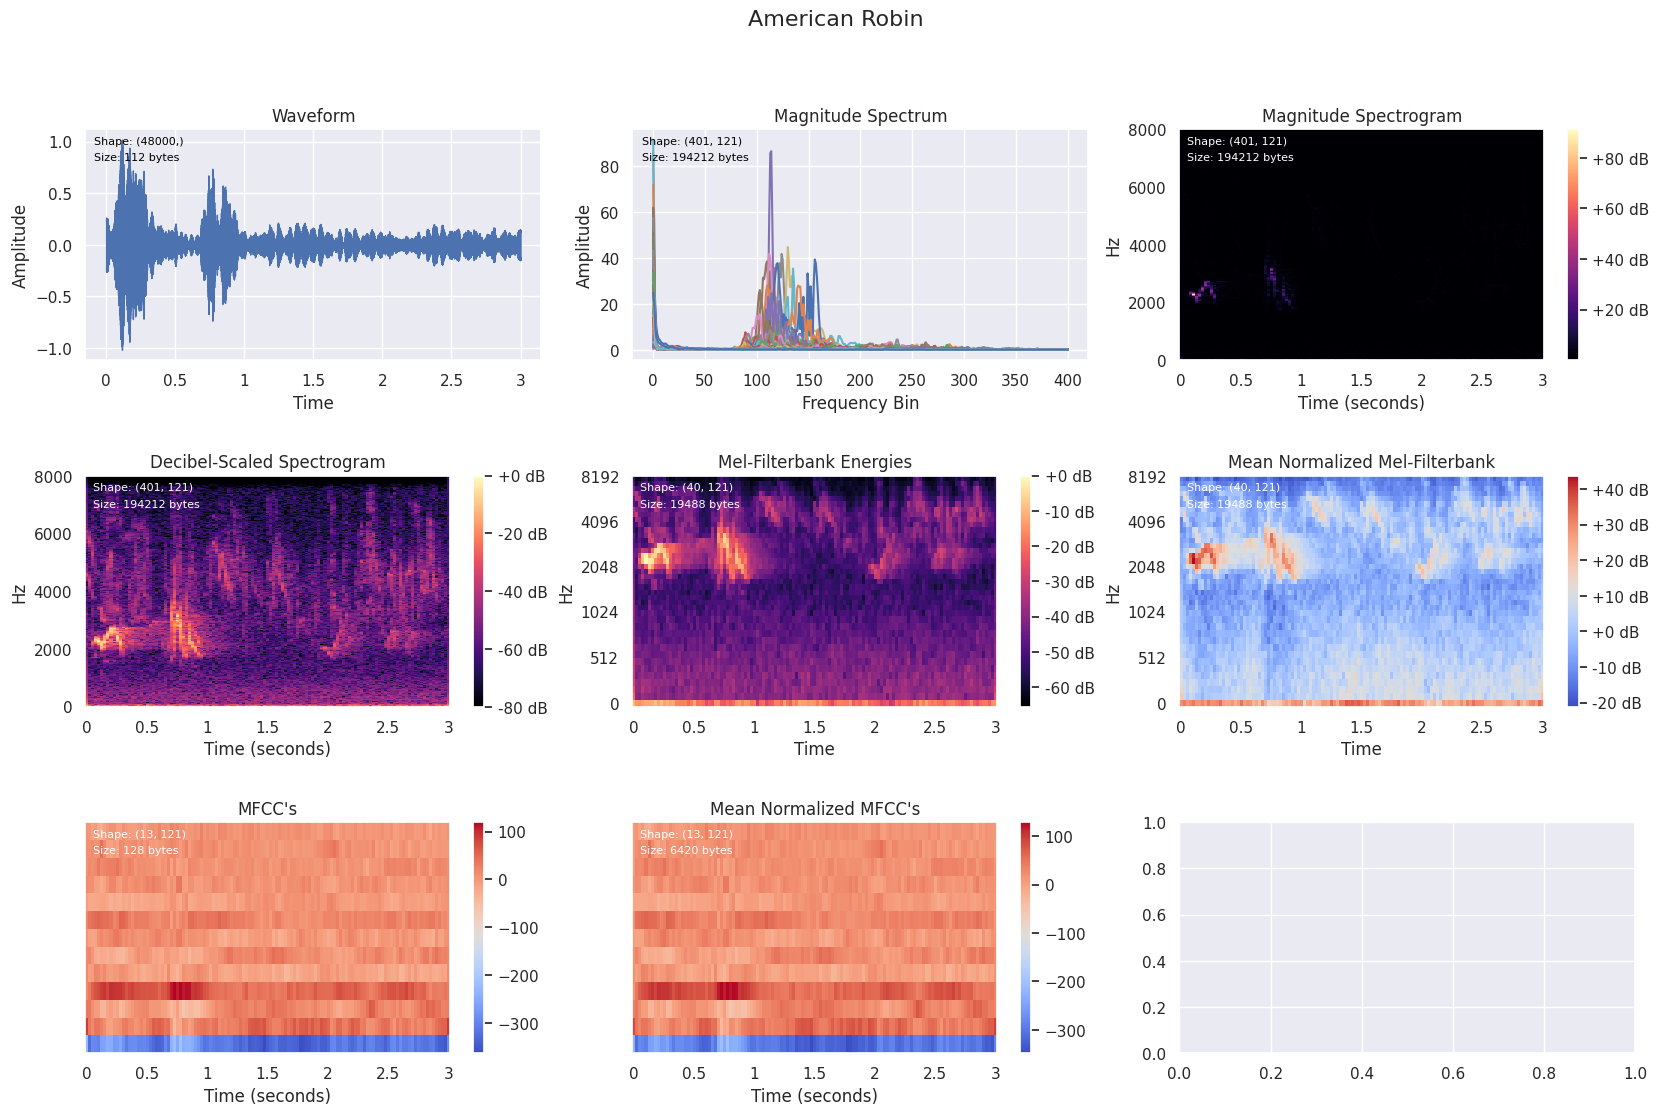

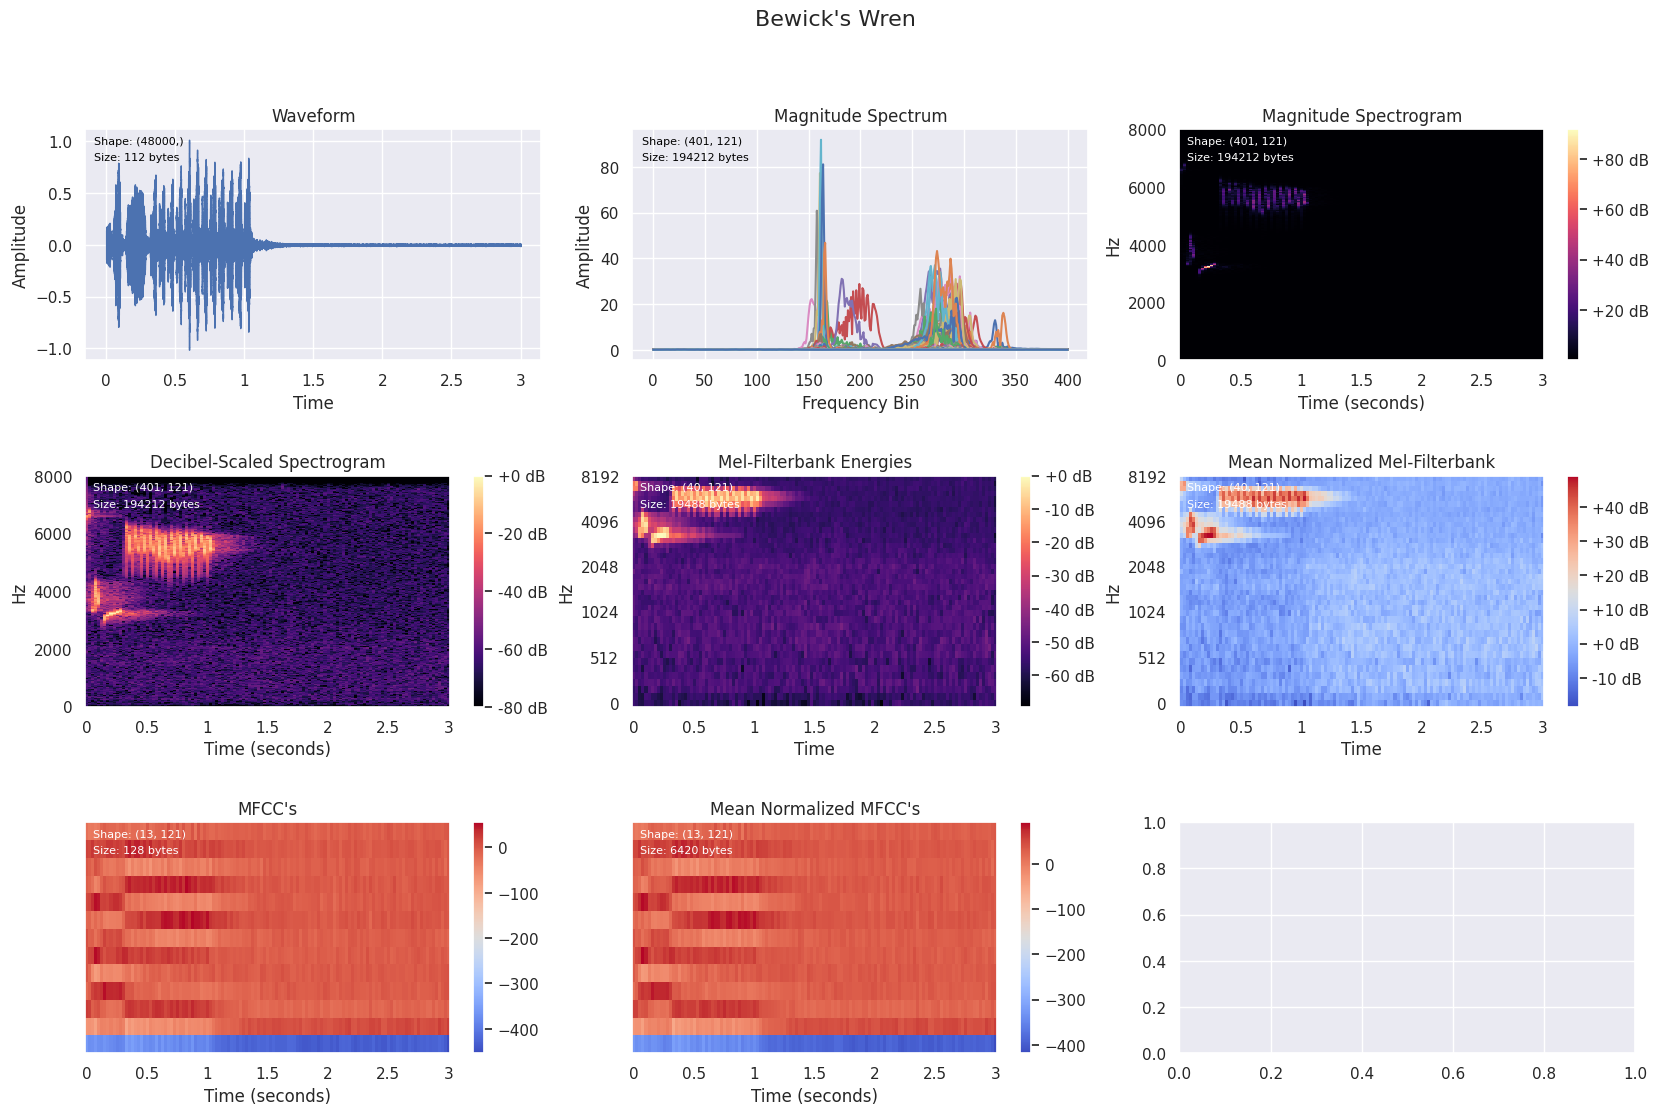

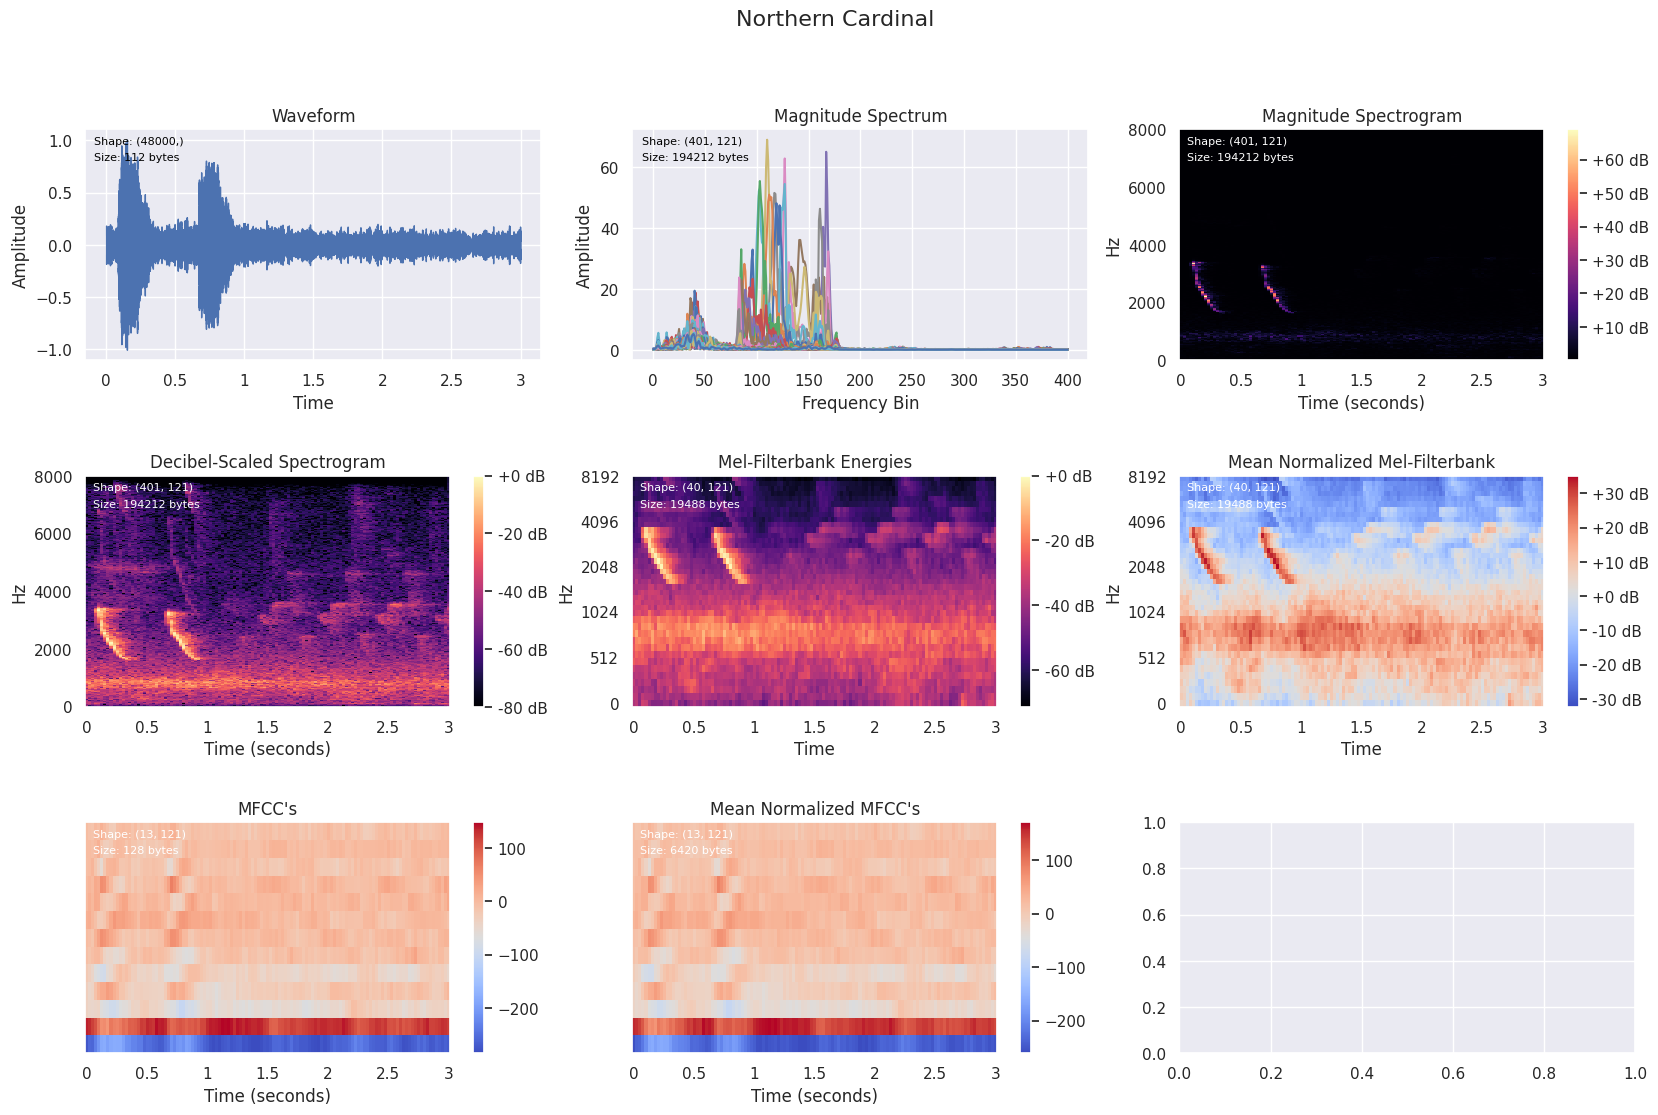

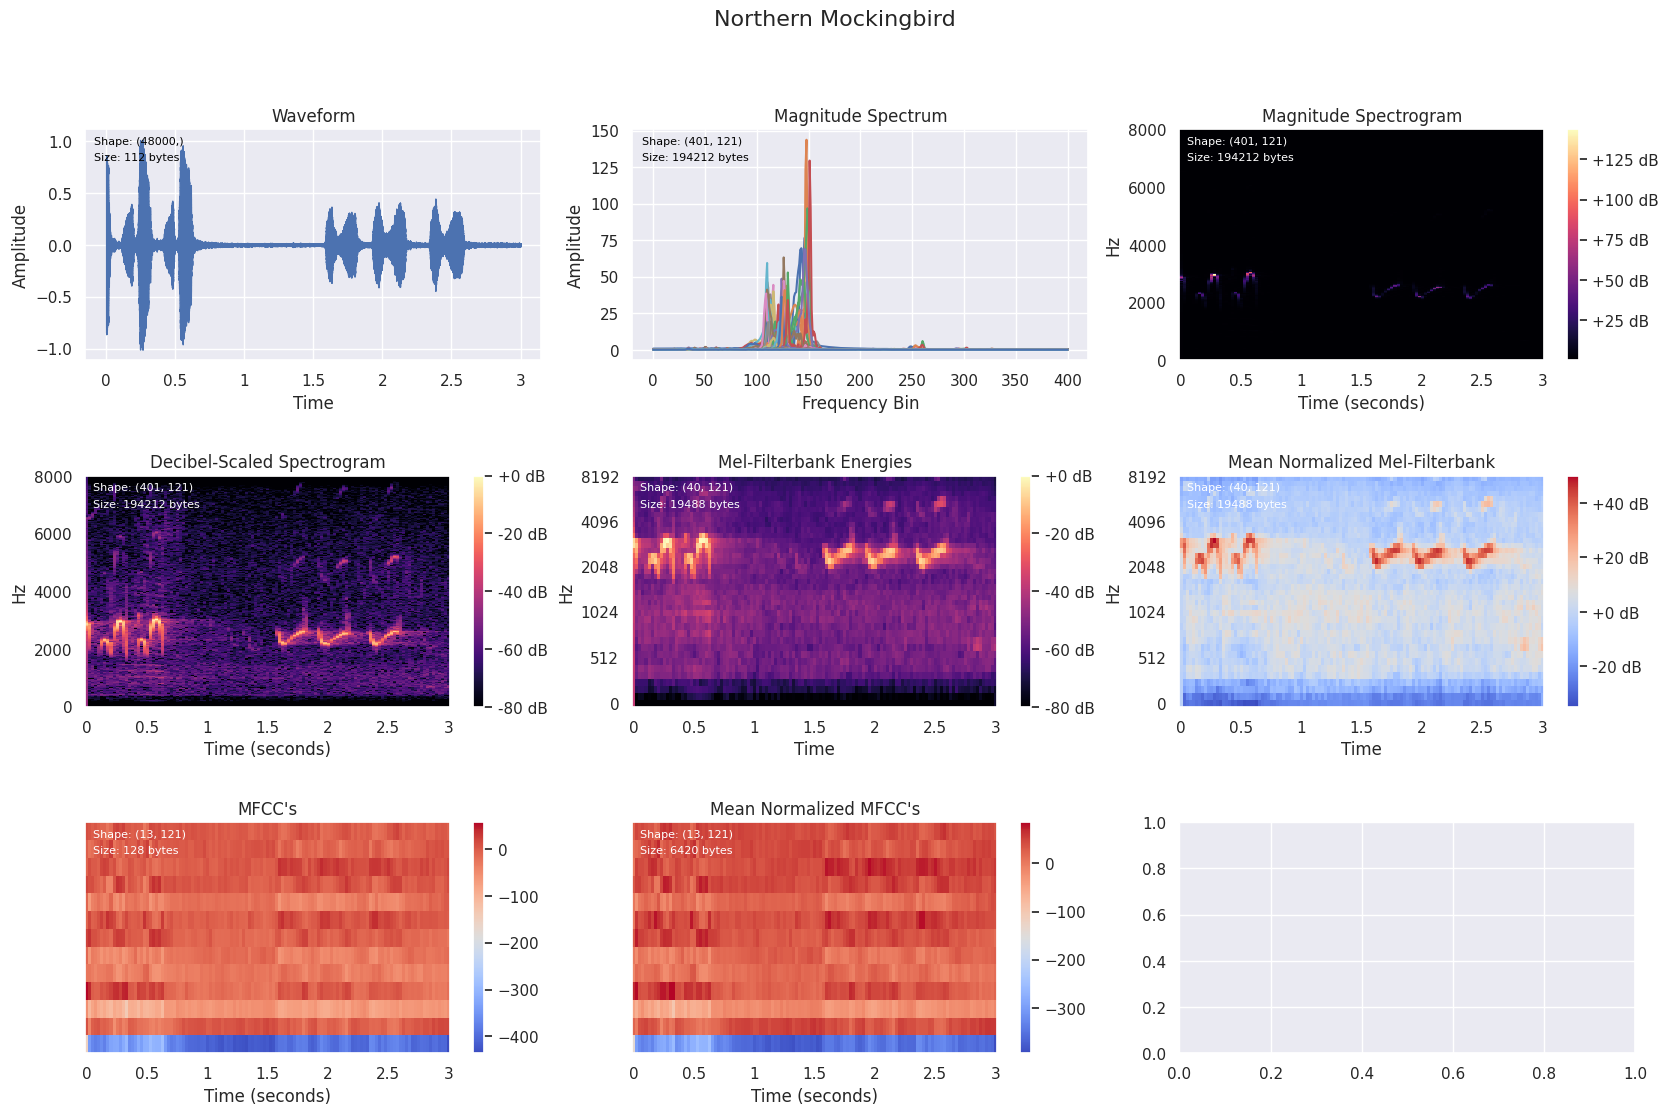

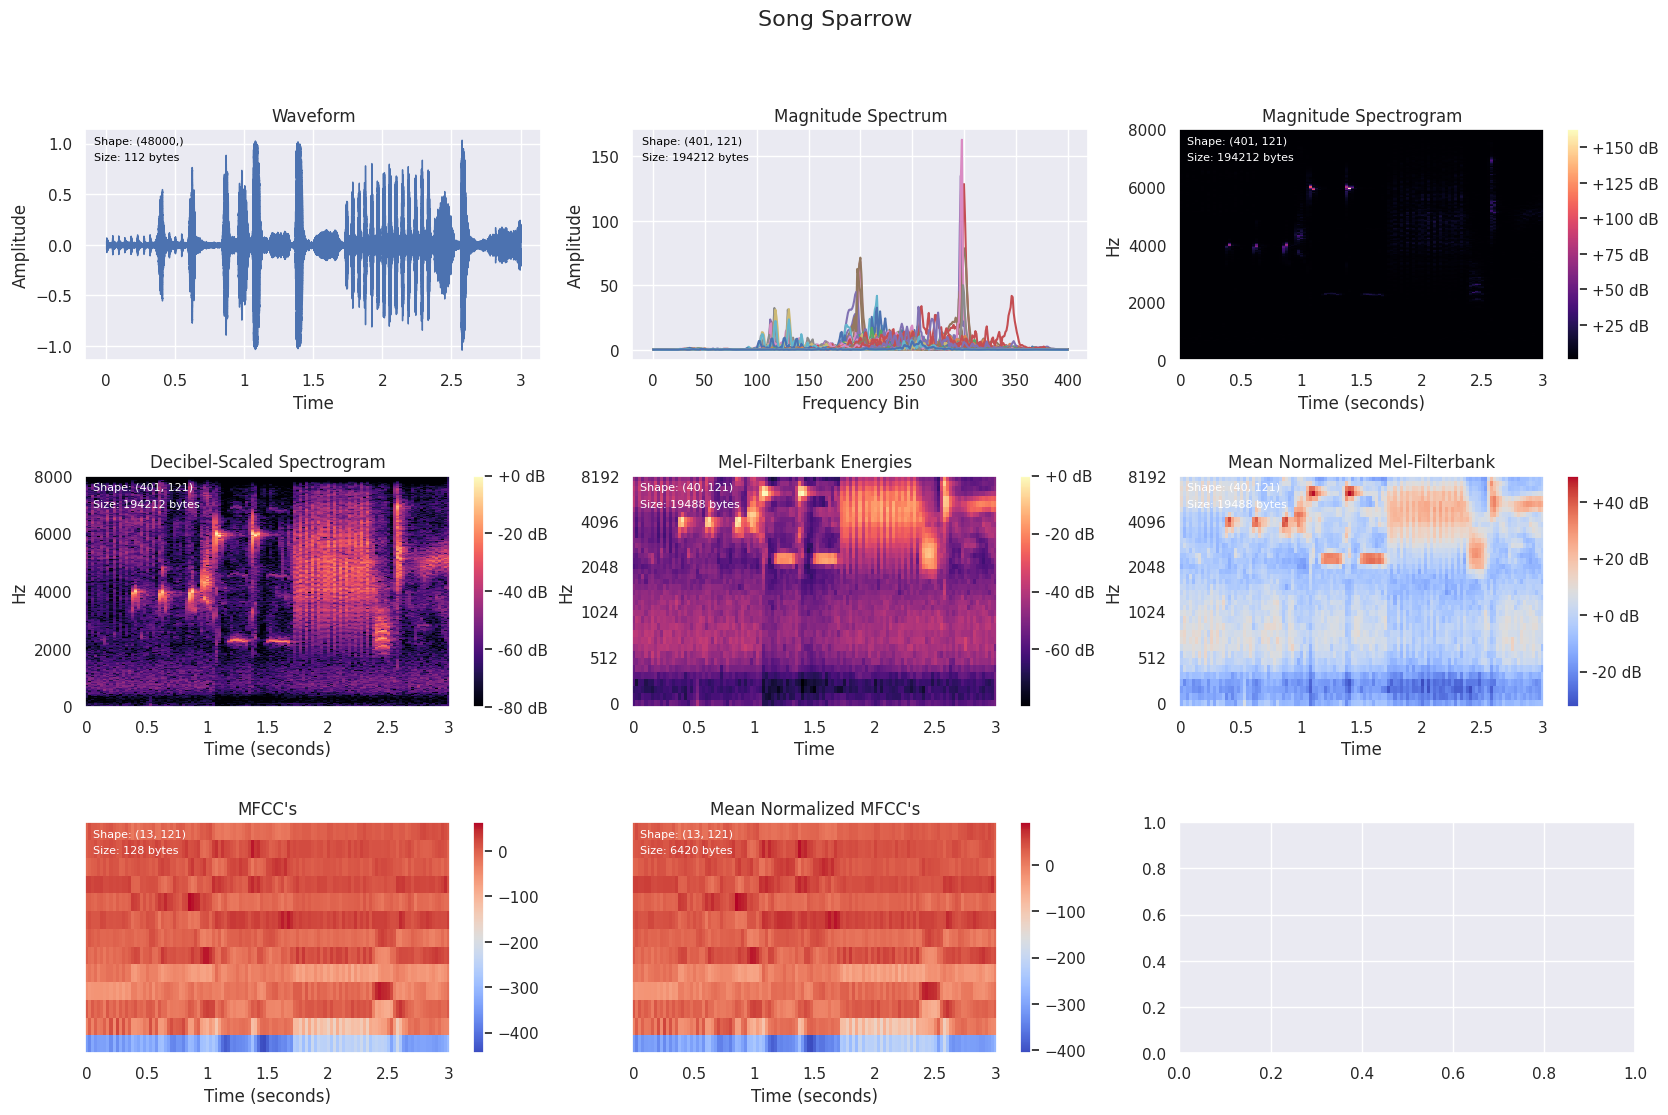

In [16]:
frame_length = 0.05
frame_stride = 0.025
sample_rate = 16000
n_fft = int(frame_length * sample_rate)
hop_length = int(frame_stride * sample_rate)
n_mels = 40
n_mfcc=13


for clip in samples.itertuples():
  full_path = f"data/wavfiles/{clip.filename}"
  y, sr = librosa.load(full_path, sr=sample_rate)
  display(Audio(full_path, rate=sr))

  fig, axes = plt.subplots(3, 3, figsize=(20, 12))
  fig.suptitle(f'{clip.name}', fontsize=16)
  fig.subplots_adjust(hspace=0.5)

  axes[0,0].set_title('Waveform')
  axes[0,0].set_ylabel('Amplitude')
  librosa.display.waveshow(y, sr=sr, ax=axes[0,0])
  axes[0,0].text(0.02, 0.97, f'Shape: {np.shape(y)}', transform=axes[0,0].transAxes, ha='left', va='top', fontsize=8, color='black')
  axes[0,0].text(0.02, 0.9, f'Size: {sys.getsizeof(y)} bytes', transform=axes[0,0].transAxes, ha='left', va='top', fontsize=8, color='black')


  axes[0,1].set_title('Magnitude Spectrum')
  axes[0,1].set_xlabel('Frequency Bin');
  axes[0,1].set_ylabel('Amplitude');
  stft_magnitudes = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)) # the magnitude of frequency bin f at frame t
  axes[0,1].plot(stft_magnitudes);
  axes[0,1].text(0.02, 0.97, f'Shape: {np.shape(stft_magnitudes)}', transform=axes[0,1].transAxes, ha='left', va='top', fontsize=8, color='black')
  axes[0,1].text(0.02, 0.9, f'Size: {sys.getsizeof(stft_magnitudes)} bytes', transform=axes[0,1].transAxes, ha='left', va='top', fontsize=8, color='black')


  axes[0,2].set_title('Magnitude Spectrogram')
  stft_magnitudes = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)) # the magnitude of frequency bin f at frame t
  spec_img = librosa.display.specshow(stft_magnitudes, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear', ax=axes[0,2])
  fig.colorbar(spec_img, ax=axes[0,2], format="%+2.f dB");
  axes[0,2].text(0.02, 0.97, f'Shape: {np.shape(stft_magnitudes)}', transform=axes[0,2].transAxes, ha='left', va='top', fontsize=8, color='white')
  axes[0,2].text(0.02, 0.9, f'Size: {sys.getsizeof(stft_magnitudes)} bytes', transform=axes[0,2].transAxes, ha='left', va='top', fontsize=8, color='white')


  axes[1,0].set_title('Decibel-Scaled Spectrogram')
  S_db = librosa.amplitude_to_db(stft_magnitudes, ref=np.max)
  db_spec_img = librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear', ax=axes[1,0])
  fig.colorbar(db_spec_img, ax=axes[1,0], format="%+2.f dB");
  axes[1,0].text(0.02, 0.97, f'Shape: {np.shape(S_db)}', transform=axes[1,0].transAxes, ha='left', va='top', fontsize=8, color='white')
  axes[1,0].text(0.02, 0.9, f'Size: {sys.getsizeof(S_db)} bytes', transform=axes[1,0].transAxes, ha='left', va='top', fontsize=8, color='white')


  axes[1,1].set_title('Mel-Filterbank Energies')
  mel_s = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  mfe = librosa.power_to_db(mel_s, ref=np.max)
  mfe_img = librosa.display.specshow(mfe, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[1,1])
  fig.colorbar(mfe_img, ax=axes[1,1], format="%+2.f dB");
  axes[1,1].text(0.02, 0.97, f'Shape: {np.shape(mfe)}', transform=axes[1,1].transAxes, ha='left', va='top', fontsize=8, color='white')
  axes[1,1].text(0.02, 0.9, f'Size: {sys.getsizeof(mfe)} bytes', transform=axes[1,1].transAxes, ha='left', va='top', fontsize=8, color='white')


  axes[1,2].set_title('Mean Normalized Mel-Filterbank')
  mfe_mean_normalized = mfe - (np.mean(mfe, axis=0) + 1e-8)
  mfe_norm_img = librosa.display.specshow(mfe_mean_normalized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[1,2])
  fig.colorbar(mfe_norm_img, ax=axes[1,2], format="%+2.f dB");
  axes[1,2].text(0.02, 0.97, f'Shape: {np.shape(mfe_mean_normalized)}', transform=axes[1,2].transAxes, ha='left', va='top', fontsize=8, color='white')
  axes[1,2].text(0.02, 0.9, f'Size: {sys.getsizeof(mfe_mean_normalized)} bytes', transform=axes[1,2].transAxes, ha='left', va='top', fontsize=8, color='white')

  axes[2,0].set_title('MFCC\'s')
  axes[2,0].set_ylabel('Coefficients')
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
  mffc_img = librosa.display.specshow(mfccs, hop_length=hop_length, sr=sr, x_axis='s', ax=axes[2,0])
  fig.colorbar(mffc_img, ax=axes[2,0]);
  axes[2,0].text(0.02, 0.97, f'Shape: {np.shape(mfccs)}', transform=axes[2,0].transAxes, ha='left', va='top', fontsize=8, color='white')
  axes[2,0].text(0.02, 0.9, f'Size: {sys.getsizeof(mfccs)} bytes', transform=axes[2,0].transAxes, ha='left', va='top', fontsize=8, color='white')

  axes[2,1].set_title('Mean Normalized MFCC\'s')
  axes[2,1].set_ylabel('Coefficients')
  mfcc_mean_normalized = mfccs - (np.mean(mfccs, axis=0) + 1e-8)
  mffc_normalized_img = librosa.display.specshow(mfcc_mean_normalized, hop_length=hop_length, sr=sr, x_axis='s', ax=axes[2,1])
  fig.colorbar(mffc_normalized_img, ax=axes[2,1]);
  axes[2,1].text(0.02, 0.97, f'Shape: {np.shape(mfcc_mean_normalized)}', transform=axes[2,1].transAxes, ha='left', va='top', fontsize=8, color='white')
  axes[2,1].text(0.02, 0.9, f'Size: {sys.getsizeof(mfcc_mean_normalized)} bytes', transform=axes[2,1].transAxes, ha='left', va='top', fontsize=8, color='white')

  plt.show()

  display(HTML("<div style='margin-bottom: 20px;'></div>"))

# Import Data to Edge Impulse

One issue this dataset has is that not every wav file in the zip is actually in the bird_songs_metadata.csv. Since we don't have a label for it won't be usable in training and so we create a new zip file we can export for training in Edge Impulse.

In [17]:
!rm -rf export # remove the old directory if starting from scratch.

1. As observed in the EDA above the dataset is imbalanced and so we random

In [18]:
balanced_ds = metadata.groupby('name').apply(lambda x: x.head(200)).reset_index(drop=True)

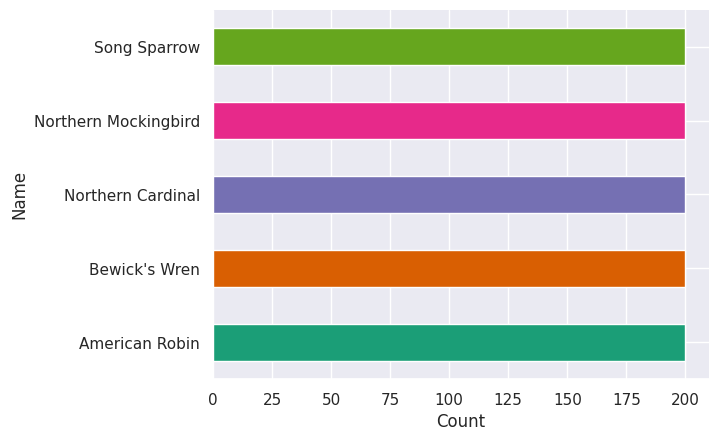

In [19]:
# @title Balanced Dataset

balanced_bird_counts = balanced_ds.groupby('name').size()

balanced_bird_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Count')
plt.ylabel('Name')
plt.gca().spines[['top', 'right',]].set_visible(False)

1. Create a new folder with all the wave files that have metadata.

In [20]:
filenames = np.squeeze('data/wavfiles/' + balanced_ds['filename'].values)

In [21]:
import shutil
import re

os.makedirs('export', exist_ok=True)

for i, file in enumerate(filenames):
  shutil.copy2(file, os.path.join('export', balanced_ds['filename'][i]))

2. In order to correctly identify the label associated with each wave file in the original archive the bird_songs_metadata.csv file that is loaded into the metadata variable needs to be translated to the [json format Edge Impulse understands](https://edge-impulse.gitbook.io/docs/edge-impulse-studio/data-acquisition/uploader#edge-impulse-exporter-format-info.labels-files).

In [22]:
import json

ei_metadata = {
    "version": 1,
    "files": []
}

for row in balanced_ds.itertuples():
    file = {
        "path": f"{row.filename}",
        "category": "split",
        "label": { "type": "label", "label": f"{row.name}" },
        "metadata": {
            "genus": f"{row.genus}",
            "species": f"{row.species}",
            "subspecies": f"{row.subspecies}",
            "name": f"{row.name}",
            "recordist": f"{row.recordist}",
            "country": f"{row.country}",
            "location": f"{row.location}",
            "latitude": f"{row.latitude}",
            "longitude": f"{row.longitude}",
            "altitude": f"{row.altitude}",
            "sound_type": f"{row.sound_type}",
            "source_url": f"{row.source_url}",
            "license": f"{row.license}",
            "time": f"{row.time}",
            "date": f"{row.date}",
            "remarks": f"{row.remarks}",
            "filename": f"{row.filename}"
        }
      }
    ei_metadata['files'].append(file)

with open('export/info.labels', 'w') as json_file:
    json.dump(ei_metadata, json_file, indent=4)

3. Create the zipfile

In [23]:
shutil.make_archive('edge_impulse_import', 'zip', 'export')

'/content/edge_impulse_import.zip'

4. If one is starting a new Edge Impulse project, you can download the zip file created above and import the data. The info.labels file in the zip will correctly label and assign metadata to the files.

The current project lives at https://studio.edgeimpulse.com/public/409151/live

# References

Sound Analysis
* https://www.kaggle.com/code/mrhippo/introduction-to-sound-analysis#Deep-Learning-with-Audio
* https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
* https://www.kaggle.com/code/fizzbuzz/beginner-s-guide-to-audio-data